In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [2]:
data=pd.read_csv("Group_2_data_cleaned.csv")

In [3]:
#Dropping the unnamed column
data=data.drop('Unnamed: 0',axis=1)

In [4]:
X = data.drop(columns=['Result'])
y = data.Result.values

## Variable selection using Correlation

In [5]:
data.corr()

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
SFH,1.000000,0.375943,0.368690,0.257247,0.333703,-0.187082,0.151503,0.163182,0.043349,-0.678277
popUpWidnow,0.375943,1.000000,0.218050,0.111520,0.167760,-0.140407,0.136229,0.076815,0.123399,-0.509749
SSLfinal_State,0.368690,0.218050,1.000000,0.057239,0.088525,-0.171719,0.095055,0.208091,0.108000,-0.518762
Request_URL,0.257247,0.111520,0.057239,1.000000,0.337277,-0.045858,0.048431,0.053348,0.013346,-0.271609
URL_of_Anchor,0.333703,0.167760,0.088525,0.337277,1.000000,-0.092045,0.097581,0.069178,0.039412,-0.287007
web_traffic,-0.187082,-0.140407,-0.171719,-0.045858,-0.092045,1.000000,-0.108204,-0.683857,-0.094957,0.243896
URL_Length,0.151503,0.136229,0.095055,0.048431,0.097581,-0.108204,1.000000,0.075338,0.165152,-0.183061
age_of_domain,0.163182,0.076815,0.208091,0.053348,0.069178,-0.683857,0.075338,1.000000,0.040379,-0.231931
having_IP_Address,0.043349,0.123399,0.108000,0.013346,0.039412,-0.094957,0.165152,0.040379,1.000000,-0.059225
Result,-0.678277,-0.509749,-0.518762,-0.271609,-0.287007,0.243896,-0.183061,-0.231931,-0.059225,1.000000


<AxesSubplot:>

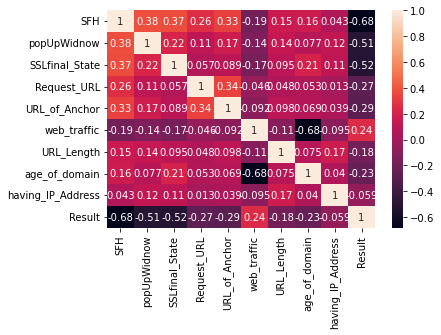

In [6]:
sns.heatmap(data=data.corr(), annot=True) #, cmap="coolwarm");

#### From, the above correlation matrix, 'age_of_domain' and 'web_traffic' are in strong negative correlation with correlation coefficient -0.68. Hence, one out of this two can be eliminated for data modelling.

## Variable selection using LASSO

In [7]:
model = LogisticRegression(solver='liblinear',penalty='l1').fit(X, y)

pd.DataFrame({'feature names':model.feature_names_in_, 'coef': list(model.coef_[0])})

,feature names,coef
0,SFH,1.562902
1,popUpWidnow,1.674627
2,SSLfinal_State,1.305904
3,Request_URL,0.926130
4,URL_of_Anchor,0.295216
5,web_traffic,-0.086860
6,URL_Length,-0.105302
7,age_of_domain,0.184797
8,having_IP_Address,-0.596621


#### We consider only those features that have a coefficient different from 0. So from the features above we can discard web_traffic as it is nearer to 0 i.e it has 0 importance.

## Validating Performance of the models with selected feature

In [8]:
# X_selected = data[['SFH', 'popUpWidnow', 'SSLfinal_State', 'Request_URL']]
X_selected = data.drop(columns=['Result','web_traffic'])
y_selected = data.Result.values

In [9]:
#splitting the train and test data
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(X_selected, y_selected,random_state=42,stratify=y, test_size=0.25 )

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [10]:
from imblearn.over_sampling import SMOTE
X_sampled, y_sampled= SMOTE().fit_resample(X_train_full,y_train_full)

In [11]:
from sklearn.svm import SVC
#Now train the model
svm_classifier=SVC(kernel='rbf',C= 1, gamma=1)
svm_classifier.fit(X_sampled,y_sampled)
svm_classifier

SVC(C=1, gamma=1)

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cnf=confusion_matrix(y_valid,svm_classifier.predict(X_valid))
cnf

array([[123,   3,   8],
       [  0,  21,   0],
       [  4,   3,  92]], dtype=int64)

Text(0.5, 1.1, 'Confusion matrix')

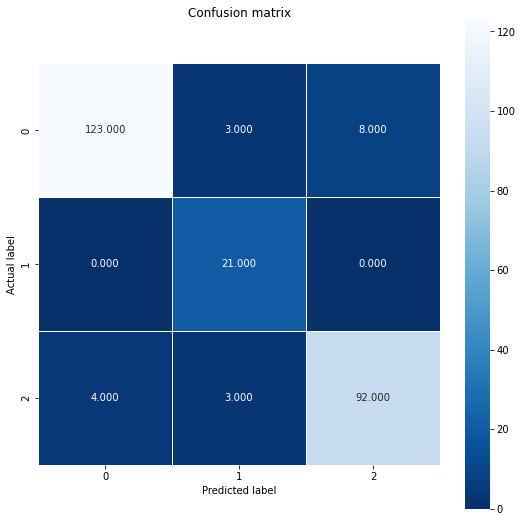

In [13]:
#plotting the confusion matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(9,9))
sns.heatmap(cnf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion matrix', y=1.1)

In [14]:
print(classification_report(y_valid,svm_classifier.predict(X_valid) ))

              precision    recall  f1-score   support

          -1       0.97      0.92      0.94       134
           0       0.78      1.00      0.88        21
           1       0.92      0.93      0.92        99

    accuracy                           0.93       254
   macro avg       0.89      0.95      0.91       254
weighted avg       0.93      0.93      0.93       254



## using selected variable on best model from part-2

In [15]:
from sklearn.ensemble import RandomForestClassifier
model_best_part2 = RandomForestClassifier(max_depth=70, max_features='log2', n_estimators=62)
model_best_part2.fit(X_sampled, y_sampled)

RandomForestClassifier(max_depth=70, max_features='log2', n_estimators=62)

In [16]:
cnf_part2=confusion_matrix(y_valid,model_best_part2.predict(X_valid))
cnf_part2

array([[124,   3,   7],
       [  0,  21,   0],
       [  2,   3,  94]], dtype=int64)

Text(0.5, 1.1, 'Confusion matrix')

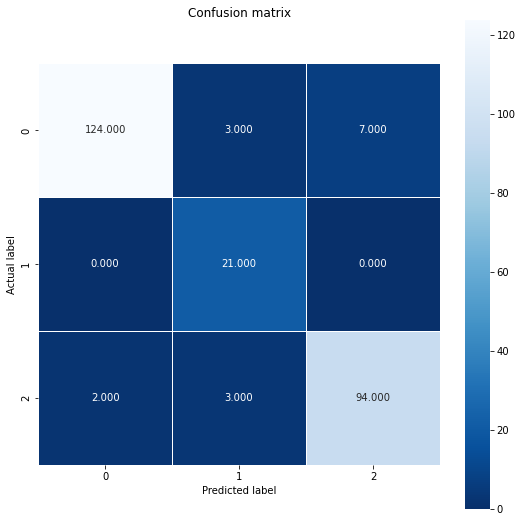

In [17]:
#plotting the confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cnf_part2, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion matrix', y=1.1)

In [18]:
print(classification_report(y_valid,model_best_part2.predict(X_valid) ))

              precision    recall  f1-score   support

          -1       0.98      0.93      0.95       134
           0       0.78      1.00      0.88        21
           1       0.93      0.95      0.94        99

    accuracy                           0.94       254
   macro avg       0.90      0.96      0.92       254
weighted avg       0.95      0.94      0.94       254

